In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import torch.utils.data as Data
from PIL import Image
from scipy import stats
import torch
import torchvision.transforms as transforms
from math import inf
import torch
import numpy as np
from scipy.stats import truncnorm
from torch.nn import functional as F
from math import inf
from torchvision import datasets, transforms


def transform_target(label):
    label = np.array(label)
    target = torch.from_numpy(label).long()
    return target

def data_split(data, targets, split_percentage, seed=1):

    num_samples = int(targets.shape[0])
    np.random.seed(int(seed))
    train_set_index = np.random.choice(num_samples, int(num_samples*split_percentage), replace=False)
    index = np.arange(data.shape[0])
    val_set_index = np.delete(index, train_set_index)
    train_set, val_set = data[train_set_index, :], data[val_set_index, :]
    train_labels, val_labels = targets[train_set_index], targets[val_set_index]

    return train_set, val_set, train_labels, val_labels

class cifar10_dataset(Data.Dataset):
    def __init__(self, train=True, transform=None, target_transform=None, noise_rate=0.8, split_percentage=0.9, seed=1, num_classes=10, feature_size=3*32*32, norm_std=0.1):

        self.transform = transform
        self.target_transform = target_transform
        self.train = train

        original_images = np.load('/content/drive/MyDrive/Colab Notebooks/data/cifar10/train_images.npy')
        original_labels = np.load('/content/drive/MyDrive/Colab Notebooks/data/cifar10/train_labels.npy')
        data = torch.from_numpy(original_images).float()
        targets = torch.from_numpy(original_labels)

        dataset = zip(data, targets)
        new_labels = get_instance_noisy_label(noise_rate, dataset, targets, num_classes, feature_size, norm_std, seed)


        self.train_data, self.train_labels= original_images, new_labels
        print(self.train_data.shape)
        self.train_data = self.train_data.reshape((-1,3,32,32))
        self.train_data = self.train_data.transpose((0, 2, 3, 1))
        print(self.train_data.shape)


    def __getitem__(self, index):

        if self.train:
            img, label = self.train_data[index], self.train_labels[index]

        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            label = self.target_transform(label)

        return img, label
    def __len__(self):

        if self.train:
            return len(self.train_data)
class cifar10_test_dataset(Data.Dataset):
    def __init__(self, transform=None, target_transform=None):

        self.transform = transform
        self.target_transform = target_transform

        self.test_data = np.load('/content/drive/MyDrive/Colab Notebooks/data/cifar10/test_images.npy')
        self.test_labels = np.load('/content/drive/MyDrive/Colab Notebooks/data/cifar10/test_labels.npy')
        self.test_data = self.test_data.reshape((10000,3,32,32))
        self.test_data = self.test_data.transpose((0, 2, 3, 1))

    def __getitem__(self, index):

        img, label = self.test_data[index], self.test_labels[index]

        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            label = self.target_transform(label)

        return img, label

    def __len__(self):
        return len(self.test_data)

In [ ]:
def get_instance_noisy_label(n, dataset, labels, num_classes, feature_size, norm_std, seed):
    # n -> noise_rate
    # dataset -> mnist, cifar10 # not train_loader
    # labels -> labels (targets)
    # label_num -> class number
    # feature_size -> the size of input images (e.g. 28*28)
    # norm_std -> default 0.1
    # seed -> random_seed
    print("building dataset...")
    label_num = num_classes
    np.random.seed(int(seed))
    torch.manual_seed(int(seed))
    torch.cuda.manual_seed(int(seed))

    P = []
    flip_distribution = stats.truncnorm((0 - n) / norm_std, (1 - n) / norm_std, loc=n, scale=norm_std)
    flip_rate = flip_distribution.rvs(labels.shape[0])

    if isinstance(labels, list):
        labels = torch.FloatTensor(labels)
    labels = labels.cuda()

    W = np.random.randn(label_num, feature_size, label_num)


    W = torch.FloatTensor(W).cuda()
    for i, (x, y) in enumerate(dataset):
        # 1*m *  m*10 = 1*10
        x = x.cuda()
        A = x.view(1, -1).mm(W[y]).squeeze(0)
        A[y] = -inf
        A = flip_rate[i] * F.softmax(A, dim=0)
        A[y] += 1 - flip_rate[i]
        P.append(A)
    P = torch.stack(P, 0).cpu().numpy()
    l = [i for i in range(label_num)]
    new_label = [np.random.choice(l, p=P[i]) for i in range(labels.shape[0])]
    record = [[0 for _ in range(label_num)] for i in range(label_num)]

    for a, b in zip(labels, new_label):
        a, b = int(a), int(b)
        record[a][b] += 1


    pidx = np.random.choice(range(P.shape[0]), 1000)
    cnt = 0
    for i in range(1000):
        if labels[pidx[i]] == 0:
            a = P[pidx[i], :]
            cnt += 1
        if cnt >= 10:
            break
    return np.array(new_label)

In [ ]:
num_classes = 10
feature_size = 3 * 32 * 32
n_epoch_1, n_epoch_2, n_epoch_3 = 5, 50, 50
dim = 512
basis = 20
iteration_nmf = 10
train_dataset = cifar10_dataset(True,
                                    transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),
                                    ]),
                                    target_transform=transform_target)
test_dataset = cifar10_dataset(   transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),
                                    ]),
                                    target_transform=transform_target)

building dataset...
(50000, 3072)
(50000, 32, 32, 3)
building dataset...
(50000, 3072)
(50000, 32, 32, 3)


In [ ]:
trainloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=16,
                                               num_workers=2,
                                               drop_last=False,
                                               shuffle=False)
testloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               batch_size=16,
                                               num_workers=2,
                                               drop_last=False,
                                               shuffle=False)

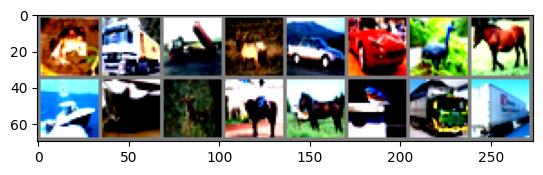

frog  horse truck horse bird  frog  car   horse ship  deer  horse cat   horse dog   truck horse


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(16)))


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)



frog  horse truck horse bird  frog  car   horse ship  deer  horse cat   horse dog   truck horse


In [ ]:
from tqdm import tqdm
loss_values = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train_loss_list = []

for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    total_batches = 0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_batches += 1

    # print average loss for the epoch
    epoch_loss = {running_loss/total_batches}
    train_loss_list.append({running_loss/total_batches})
    print(f'[{epoch + 1}] loss: {running_loss / total_batches}')

print('Finished Training')


[1] loss: 1.762964994659424
[2] loss: 1.720135647163391
[3] loss: 1.682656813583374
[4] loss: 1.6485739021492005
[5] loss: 1.6162562197303771
[6] loss: 1.5860364281845092
[7] loss: 1.5557219281196595
[8] loss: 1.5278038206672668
[9] loss: 1.4998781511688233
[10] loss: 1.4732351803207397
[11] loss: 1.4457717817687987
[12] loss: 1.4185012899398803
[13] loss: 1.3935102066993714
[14] loss: 1.3674322038459779
[15] loss: 1.3428613823509217
[16] loss: 1.3220494320869445
[17] loss: 1.294507105140686
[18] loss: 1.2739206460952759
[19] loss: 1.251423484992981
[20] loss: 1.2330934255599975
[21] loss: 1.214440436038971
[22] loss: 1.1927274539661408
[23] loss: 1.1741393627166747
[24] loss: 1.1598989590167998
[25] loss: 1.1426343107891084
[26] loss: 1.128525930519104
[27] loss: 1.1137226822948456
[28] loss: 1.0986420183753967
[29] loss: 1.0859062619400024
[30] loss: 1.0721438514232635
Finished Training


In [ ]:
import itertools


loss_liu = list(itertools.chain.from_iterable(train_loss_list))

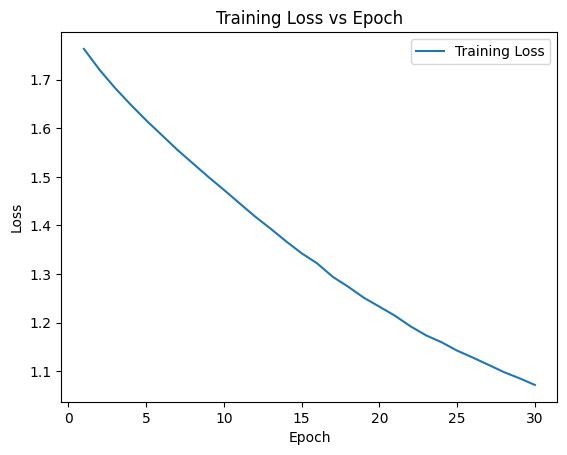

In [ ]:
import matplotlib.pyplot as plt
train_loss_list

plt.plot(range(1, 31), loss_liu, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.legend()
plt.show()

In [119]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in trainloader:
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# Build confusion matrix


In [118]:
import seaborn as sns
cf_matrix = confusion_matrix(y_true, y_pred)
norm = cf_matrix / cf_matrix.sum(axis=1, keepdims=True)
plt.figure(figsize=(19, 4))
plt.subplot(1, 2, 1)
sns.heatmap(norm, annot=True, cmap="Blues", fmt=".2f", cbar=False,
                xticklabels=[f'Class {classes[i]}' for i in range(num_classes)],
                yticklabels=[f'Class {classes[i]}' for i in range(num_classes)])
plt.title('Noise Label Transition Matrix')

ValueError: Found input variables with inconsistent numbers of samples: [10000, 160000]

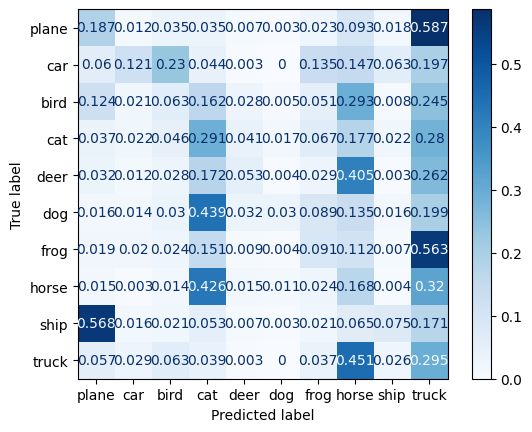

In [123]:
net.eval()
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())



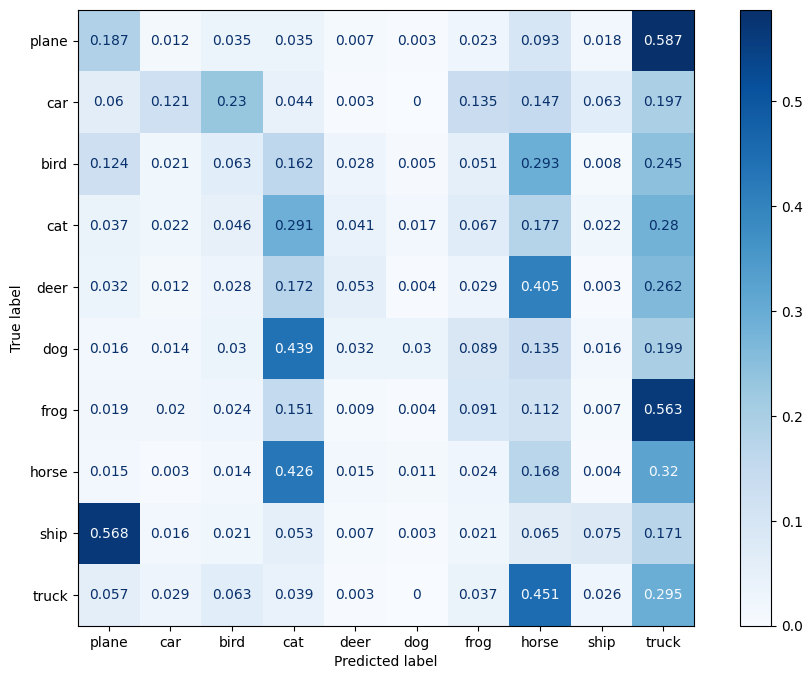

In [126]:
# Create confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# Display confusion matrix
fig, ax = plt.subplots(figsize=(12, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, values_format=".4g",ax=ax)
plt.show()

In [115]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
y_pred = []
y_true = []
# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            y_pred.extend(output)
            y_true.append(label.data.cpu().numpy())
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 18.7 %
Accuracy for class: car   is 12.1 %
Accuracy for class: bird  is 6.3 %
Accuracy for class: cat   is 29.1 %
Accuracy for class: deer  is 5.3 %
Accuracy for class: dog   is 3.0 %
Accuracy for class: frog  is 9.1 %
Accuracy for class: horse is 16.8 %
Accuracy for class: ship  is 7.5 %
Accuracy for class: truck is 29.5 %


In [117]:
y_pred


[7,
 7,
 0,
 9,
 0,
 7,
 3,
 9,
 3,
 3,
 9,
 7,
 7,
 3,
 2,
 3,
 7,
 7,
 0,
 9,
 0,
 7,
 3,
 9,
 3,
 3,
 9,
 7,
 7,
 3,
 2,
 3,
 7,
 7,
 0,
 9,
 0,
 7,
 3,
 9,
 3,
 3,
 9,
 7,
 7,
 3,
 2,
 3,
 7,
 7,
 0,
 9,
 0,
 7,
 3,
 9,
 3,
 3,
 9,
 7,
 7,
 3,
 2,
 3,
 7,
 7,
 0,
 9,
 0,
 7,
 3,
 9,
 3,
 3,
 9,
 7,
 7,
 3,
 2,
 3,
 7,
 7,
 0,
 9,
 0,
 7,
 3,
 9,
 3,
 3,
 9,
 7,
 7,
 3,
 2,
 3,
 7,
 7,
 0,
 9,
 0,
 7,
 3,
 9,
 3,
 3,
 9,
 7,
 7,
 3,
 2,
 3,
 7,
 7,
 0,
 9,
 0,
 7,
 3,
 9,
 3,
 3,
 9,
 7,
 7,
 3,
 2,
 3,
 7,
 7,
 0,
 9,
 0,
 7,
 3,
 9,
 3,
 3,
 9,
 7,
 7,
 3,
 2,
 3,
 7,
 7,
 0,
 9,
 0,
 7,
 3,
 9,
 3,
 3,
 9,
 7,
 7,
 3,
 2,
 3,
 7,
 7,
 0,
 9,
 0,
 7,
 3,
 9,
 3,
 3,
 9,
 7,
 7,
 3,
 2,
 3,
 7,
 7,
 0,
 9,
 0,
 7,
 3,
 9,
 3,
 3,
 9,
 7,
 7,
 3,
 2,
 3,
 7,
 7,
 0,
 9,
 0,
 7,
 3,
 9,
 3,
 3,
 9,
 7,
 7,
 3,
 2,
 3,
 7,
 7,
 0,
 9,
 0,
 7,
 3,
 9,
 3,
 3,
 9,
 7,
 7,
 3,
 2,
 3,
 7,
 7,
 0,
 9,
 0,
 7,
 3,
 9,
 3,
 3,
 9,
 7,
 7,
 3,
 2,
 3,
 7,
 7,
 0,
 9,
 0,
 7,
 3,
 9,
 3,
 3,
